#### Applied Machine Learning and Data Engineering in Business Context

Final Project

December 1, 2021

### Steel Plate Fault Detection

Alisa Ilina		
Anurag Singh	
Eirik Egge		
Henry Stoll		
Magnus Eliassen	
Olivia Lundholm	

# Modelling

d
# Classification

In [0]:
spark.catalog.refreshTable('steel_faults_non_oversampled_binary_train')
spark.catalog.refreshTable('steel_faults_non_oversampled_multiclass_train')
spark.catalog.refreshTable('steel_faults_oversampled_binary_train')
spark.catalog.refreshTable('steel_faults_oversampled_binary_test')
spark.catalog.refreshTable('steel_faults_oversampled_multiclass_train')
spark.catalog.refreshTable('steel_faults_oversampled_multiclass_test')

In [0]:
RUN_FAST = True
RUN_GRID_SEARCH = True
EXPERIMENT_ID=3211499312531060
RUN_NAME_PREFIX="g3"

## Libraries

In [0]:
from functools import partial
from itertools import product

import numpy as np
import pandas as pd

# track metrics with mlflow
import mlflow
# mlflow.autolog(log_models=False, exclusive=True, disable=True)

# transformation pipeline
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler, StringIndexer, RobustScaler, UnivariateFeatureSelector

# grid search & parameters
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# classification algorithms
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier, NaiveBayes, MultilayerPerceptronClassifier
from sparkdl.xgboost import XgboostClassifier

# evaluation 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# select data
def get_data(table_name: str) -> tuple : 
    return [spark.sql(f"SELECT * from steel_faults_oversampled_{table_name}_{table_version}") for table_version in ["train", "test"]]
    
df_mc_train, df_mc_test = get_data("multiclass")
df_b_train, df_b_test = get_data("binary")


y_mc_true, y_b_true = [df.select("label").collect() for df in [df_mc_test, df_b_test]]

d
 ## Pipeline

In [0]:
#            data       
# categorical | numerical
#    |             |
#    |    VectorAssember_numerical -> numerical_features
#    |             |
#    |      UnivariateFeatureSelector -> selected_features
#    |             |
#    |          RobustScaler -> scaled_features
#    |-------------|
#           |
#      VectorAssember -> features
# 


evaluator_test = None

class_names = ['Bumps', 'Dirtiness', 'K_Scratch', 'Other_Faults', 'Pastry', 'Stains', 'Z_Scratch']
target_columns = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults", "label"]
categorical_feature_columns = ['TypeOfSteel_A300', 'TypeOfSteel_A400']
numerical_feature_columns = df_mc_test.drop(*target_columns + categorical_feature_columns).columns
assert len(numerical_feature_columns) == 25

va_numerical = VectorAssembler(inputCols=numerical_feature_columns, outputCol="numerical_features")

selector = UnivariateFeatureSelector(featuresCol='numerical_features', outputCol="selected_features", labelCol='label', selectionMode='fdr')
selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(0.05)


scaler = RobustScaler(inputCol = "selected_features", outputCol = "scaled_features", withScaling = True, withCentering = True, lower=0.25, upper=0.75)
# scaler = RobustScaler(inputCol = "numerical_features", outputCol = "scaled_features", withScaling = True, withCentering = True, lower=0.25, upper=0.75)

va = VectorAssembler(inputCols=categorical_feature_columns + ["scaled_features"], outputCol="features")

pipe = Pipeline(stages=[va_numerical, selector, scaler, va])

#hyperparameter grid search for all models
def cross_val_pipe(estimator, param_grid, evaluator):
    cv = CrossValidator(estimator=estimator,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3,
                          parallelism=1)
    return cv
#     return Pipeline(stages=[va_numerical, selector, scaler, va, cv])
#     return Pipeline(stages=[va_numerical, scaler, va, cv])


def fast_grid():
    return ParamGridBuilder().build()

def run_pipe(train, test, y_true, type_classification: str, name: str, estimator, grid=None) -> None:
    
    if (grid and not RUN_GRID_SEARCH) or (not grid and not RUN_FAST):
        return None
    
    evaluator = BinaryClassificationEvaluator() if type_classification == "binary" else MulticlassClassificationEvaluator() 
    pipe = cross_val_pipe(estimator, grid(estimator), evaluator) if grid else cross_val_pipe(estimator, fast_grid(), evaluator)
    
    title = f"{name} - {type_classification} - {'grid' if grid else 'fast'}"
    print(title)
    tags = {
        "gridsearch": 'true' if grid else 'false',
        "type_classification": type_classification,
        "experiment": RUN_NAME_PREFIX,
    }
    with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name=f"{RUN_NAME_PREFIX} {title}", tags=tags):
        model = pipe.fit(train)
        results = model.transform(test)
        mlflow.spark.log_model(model, title)

        y_true = results.select("label").collect()
        y_pred = results.select("prediction").collect()

        target_names = ["Common", "Uncommon (other)"] if type_classification == "binary" else class_names
        clf_report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

        # .iloc[:-1, :] to exclude support
        color=sns.diverging_palette(30, 164, s=60, as_cmap=True)
        sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T,cmap=color, annot=True).set(title=title)
        # save to mlflow
        plt.savefig("clf_report_heatmap.png", dpi=400, bbox_inches="tight")
        plt.show()
        mlflow.log_artifact("clf_report_heatmap.png") 


        # save metrics to mlflow
        metric = evaluator.evaluate(results)
        evaluator_test = evaluator
        metric_test = metric
        mlflow.log_metric("metric", metric)
        
        accuracy = accuracy_score(y_true, y_pred)
        mlflow.log_metric("accuracy", accuracy)
        
        print(f"Key Metrics: {accuracy=:2%} | {metric=:2%}")

pipe_fitted_mc = pipe.fit(df_mc_train)
pipe_fitted_b = pipe.fit(df_mc_train)


run_pipe_multiclass = partial(run_pipe, pipe_fitted_mc.transform(df_mc_train), pipe_fitted_mc.transform(df_mc_test), y_mc_true, "multi")
run_pipe_binary = partial(run_pipe, pipe_fitted_b.transform(df_b_train), pipe_fitted_b.transform(df_b_test), y_b_true, "binary")


## Models
Multiclass and Binary

###Baseline

In [0]:
#get baseline data
df_b_baseline_train = spark.sql(f"SELECT * from steel_faults_non_oversampled_binary_train")
df_mc_baseline_train = spark.sql(f"SELECT * from steel_faults_non_oversampled_multiclass_train")
                        
#control (count =465)
#df_b_test.groupBy("label").count().show()
#df_mc_test.groupBy("label").count().show()

In [0]:
def label_data(train, test):
    new_train, new_test = train.select('label').collect(), test.select('label').collect()
    return new_train, new_test

train_baseline_b, test_baseline_b = label_data(df_b_baseline_train, df_b_test)
train_baseline_mc, test_baseline_mc = label_data(df_mc_baseline_train, df_mc_test)


# zero rule algorithm for classification
def zero_rule_algorithm_classification(train, test):
	output_values = [row[-1] for row in train]
	prediction = max(set(output_values), key=output_values.count)
	predicted = [prediction for i in range(len(test))]
	return predicted


zero_rule_algorithm_classification(train_baseline_b, test_baseline_b)
zero_rule_algorithm_classification(train_baseline_mc, test_baseline_mc)

y_true_mc, y_true_b = test_baseline_mc, test_baseline_b
y_pred_mc = zero_rule_algorithm_classification(train_baseline_mc, test_baseline_mc) 
y_pred_b = zero_rule_algorithm_classification(train_baseline_b, test_baseline_b)

print(classification_report(y_true_mc, y_pred_mc))
print(classification_report(y_true_b, y_pred_b))


/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
 precision recall f1-score support

 0 0.00 0.00 0.00 105
 1 0.00 0.00 0.00 18
 2 0.00 0.00 0.00 86
 3 0.31 1.00 0.48 145
 4 0.00 0.00 0.00 44
 5 0.00 0.00 0.00 18
 6 0.00 0.00 0.00 49

 accuracy 0.31 465
 macro avg 0.04 0.14 0.07 465
weighted avg 0.10 0.31 0.15 465

/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 _warn_prf(average, modifier, msg_start, len(result))
 precision recall f1-score support

 0 0.69 1.00 0.82 320
 1 0.00 0.00 0.00 145

 accuracy 0.69 465
 macro avg 0.34 0.50 0.41 465
weighted avg 0.47 0.69 0.56 465

### Logistic Regression

Logistic Regression - multi - fast
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

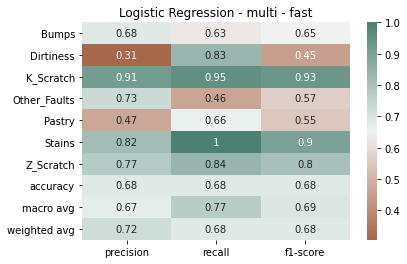

Key Metrics: accuracy=68.387097% | metric=68.486167%
Logistic Regression - multi - grid
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

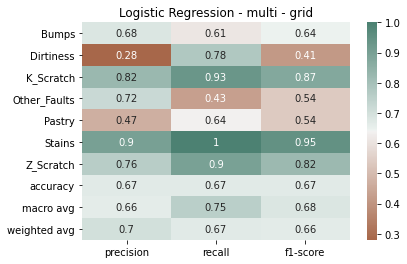

Key Metrics: accuracy=66.666667% | metric=66.455960%
Logistic Regression - binary - fast
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

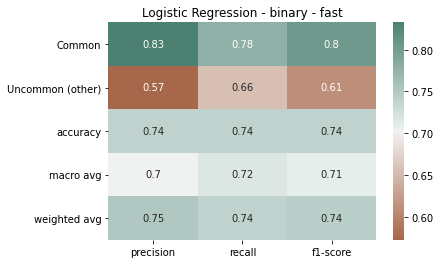

Key Metrics: accuracy=73.978495% | metric=80.435345%
Logistic Regression - binary - grid
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

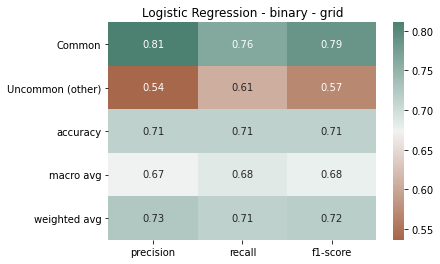

Key Metrics: accuracy=71.397849% | metric=76.321121%

In [0]:
lr_mc = LogisticRegression(maxIter=100)
lr_b = LogisticRegression(maxIter=100)


def grid_lr(model): 
    return ParamGridBuilder()\
    .addGrid(model.regParam, [1, 0.50, 0.25, 0.10, 0.01]) \
    .addGrid(model.fitIntercept, [False, True])\
    .addGrid(model.aggregationDepth, [2, 4, 6, 8]) \
    .addGrid(model.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

run_pipe_multiclass("Logistic Regression", lr_mc)
run_pipe_multiclass("Logistic Regression", lr_mc, grid=grid_lr)
run_pipe_binary("Logistic Regression", lr_b)
run_pipe_binary("Logistic Regression", lr_b, grid=grid_lr)

### Decision Trees

Decision Tree - multi - grid
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

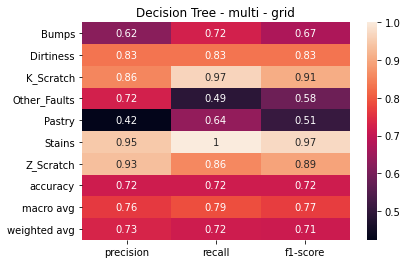

Key Metrics: accuracy=71.612903% | metric=71.344636%
Decision Tree - binary - grid
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

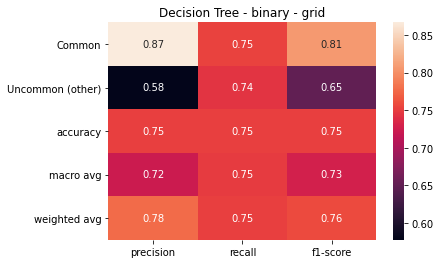

Key Metrics: accuracy=75.053763% | metric=74.519397%

In [0]:
# decision tree classifier
dt_mc = DecisionTreeClassifier(seed = 42, impurity ='entropy')
dt_b = DecisionTreeClassifier(seed = 42)


def grid_dt(model):
    return ParamGridBuilder()\
    .addGrid(model.maxDepth, [8, 6, 5, 4])\
    .addGrid(model.maxBins, [10, 20, 50])\
    .addGrid(model.impurity, ["gini", "entropy"])\
    .build()    

run_pipe_multiclass("Decision Tree", dt_mc)
run_pipe_multiclass("Decision Tree", dt_mc, grid=grid_dt)
run_pipe_binary("Decision Tree", dt_b)
run_pipe_binary("Decision Tree", dt_b, grid=grid_dt)

### Random Forest

Random Forest - multi - grid
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

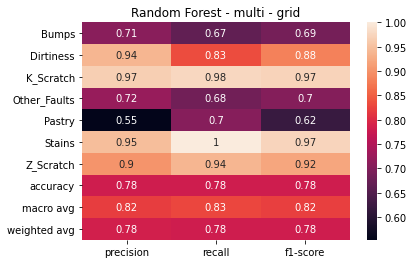

Key Metrics: accuracy=78.064516% | metric=78.094119%
Random Forest - binary - grid
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

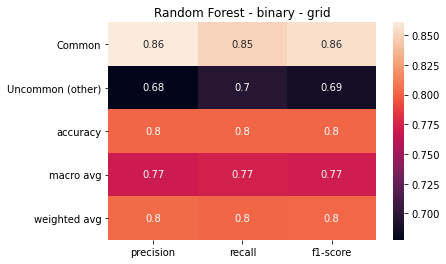

Key Metrics: accuracy=80.215054% | metric=88.161638%

In [0]:
# random forest classifier
rf_mc = RandomForestClassifier(seed = 42)
rf_b = RandomForestClassifier(seed = 42)

def grid_rf(model):
    return ParamGridBuilder()\
    .addGrid(model.numTrees, [10, 20, 48]) \
    .addGrid(model.maxDepth, [10, 5, 1, 0])\
    .addGrid(model.maxBins, [10, 20, 50])\
    .addGrid(model.impurity, ["gini", "entropy"])\
    .addGrid(model.bootstrap, [True, False])\
    .build()

run_pipe_multiclass("Random Forest", rf_mc)
run_pipe_multiclass("Random Forest", rf_mc, grid=grid_rf)
run_pipe_binary("Random Forest", rf_b)
run_pipe_binary("Random Forest", rf_b, grid=grid_rf)

### XGBoost

xgb - multi - grid
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

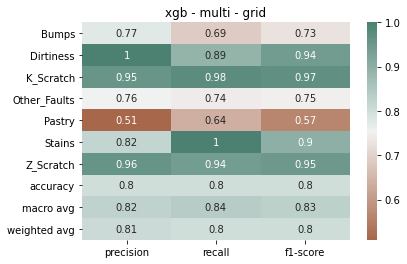

Key Metrics: accuracy=80.000000% | metric=80.140304%
xgb - binary - grid
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

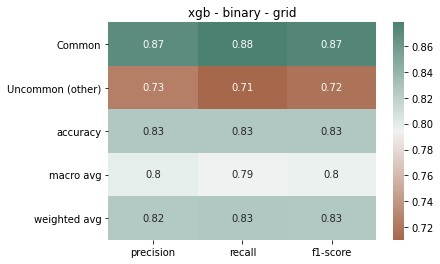

Key Metrics: accuracy=82.580645% | metric=89.603448%

In [0]:
xgb_mc = XgboostClassifier(missing=0.0, seed=42, booster="gbtree", objective='multi:softmax')
xgb_b = XgboostClassifier(missing=0.0, seed=42, booster="gbtree", objective='binary:logistic')

def grid_xgb(model):
    return ParamGridBuilder()\
    .addGrid(model.max_depth, [0, 5, 10])\
    .addGrid(model.n_estimators, [100, 150])\
    .addGrid(model.min_child_weight, [0, 5, 9])\
    .addGrid(model.reg_alpha, [1, 5, 10])\
    .build()

# run_pipe_multiclass("xgb", xgb_mc)
run_pipe_multiclass("xgb", xgb_mc, grid=grid_xgb)

# run_pipe_binary("xgb", xgb_b)
run_pipe_binary("xgb", xgb_b, grid=grid_xgb)

In [0]:
mlflow.end_run()

###MLP

mlp - multi - grid
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

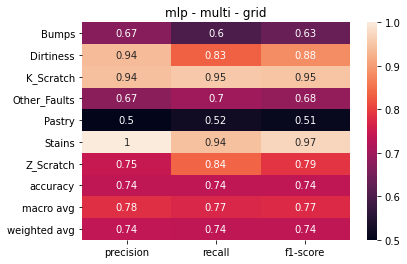

Key Metrics: accuracy=73.548387% | metric=73.502824%
mlp - binary - grid
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

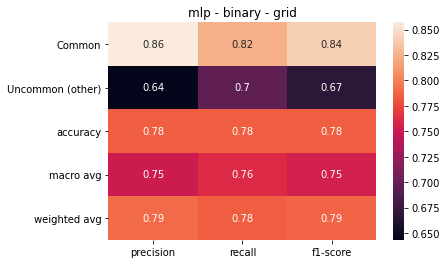

Key Metrics: accuracy=78.494624% | metric=84.250000%

In [0]:
def gen_layers(end_layers):
    return [[27] + [num_connections] * layers + [end_layers] for layers, num_connections in product(range(10), [27, 54, 108])]

mlp_mc = MultilayerPerceptronClassifier(blockSize = 128, seed = 42, maxIter = 100)
mlp_b = MultilayerPerceptronClassifier(blockSize = 128, seed = 42, maxIter = 100)

def grid_mlp(end_layers, model):
    return ParamGridBuilder()\
    .addGrid(model.layers, gen_layers(end_layers))\
    .build()

grid_mlp_mc = partial(grid_mlp, 7)
grid_mlp_b = partial(grid_mlp, 2)

run_pipe_multiclass("mlp", mlp_mc)
run_pipe_multiclass("mlp", mlp_mc, grid=grid_mlp_mc)
run_pipe_binary("mlp", mlp_b)
run_pipe_binary("mlp", mlp_b, grid=grid_mlp_b)

###SVC

svc - binary - grid
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

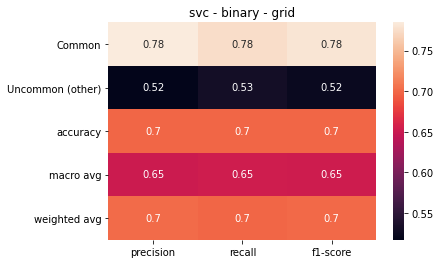

Key Metrics: accuracy=69.892473% | metric=75.543103%

In [0]:
# linear support vector machine (only binary)
svc = LinearSVC()

def grid_svc( model):
    return ParamGridBuilder()\
    .addGrid(svc.maxIter, [5, 10, 20]) \
    .addGrid(svc.regParam, [0.001, 0.01, 1.0, 10.0])\
    .build()

#run_pipe_binary("svc", svc)
run_pipe_binary("svc", svc, grid=grid_svc)

###GBT

gbt - binary - grid
MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

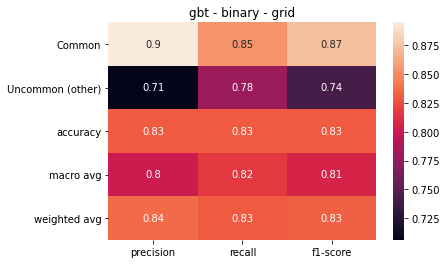

Key Metrics: accuracy=83.010753% | metric=88.219828%

In [0]:
gbt = GBTClassifier(seed = 42, maxIter = 100)


def grid_gbt( model):
    return ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [ 2,3,4]) \
    .addGrid(gbt.minInfoGain, [0.0, 0.1, 0.2, 0.3])\
    .addGrid(gbt.stepSize, [0.05, 0.1, 0.2, 0.4])\
    .addGrid(gbt.maxBins, [10, 20, 40])\
    .build()

#run_pipe_binary("gbt", gbt)
run_pipe_binary("gbt", gbt, grid=grid_gbt)

In [0]:
dt_pipe_display = Pipeline(stages=[va_numerical, selector, scaler, va, dt_mc])
model_dt_display = dt_pipe_display.fit(df_mc_train)
display(model_dt_display.stages[-1])